## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'range': {'timestamp': {'gte': '2016-09-15', 'lt': '2016-09-30'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteOWDServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteOWDServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    }
}

scroll = list(scan(client=es, query=my_query))


In [4]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
for res in scroll:
    if count<1: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
    elif column_type == 'traceroute':
        data[s].set_value( ts, 'hash', res['_source']['hash'])
print(count)

{'_index': 'network_weather_2-2016.9.15', '_type': 'packet_loss_rate', '_id': 'AVcsjD01sPCefqD7eAFr', '_source': {'timestamp': 1473916200000, 'destSite': 'pic', 'packet_loss': 0.0, 'dest': '193.109.172.188', 'srcProduction': True, 'MA': '128.142.223.247', 'src': '128.142.223.247', 'srcSite': 'CERN-PROD', 'destVO': 'ATLAS', 'srcVO': 'ATLAS', 'destProduction': True}, '_score': 0.0}
9089


In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

data[dS].sort_index(inplace=True) 
data[dS].describe()

,delay_median,delay_mean,delay_sd,packet_loss,hash,throughput
count,2030.000000,2030.000000,2030.000000,2036.000000,3.590000e+02,119.000000
mean,28.303177,28.828414,8.112268,0.002224,-3.686070e+18,1.656714
std,21.571907,21.088692,22.134968,0.004408,5.297700e+16,2.021552
min,14.200000,14.451600,0.056921,0.000000,-3.692968e+18,0.007024
25%,15.300000,15.369833,0.698570,0.000000,-3.692968e+18,0.043936
50%,15.400000,15.581117,3.265651,0.000000,-3.692968e+18,0.061728
75%,48.475000,50.010842,11.794107,0.002542,-3.692968e+18,3.802932
max,73.500000,102.562767,470.351413,0.025000,-3.280288e+18,5.261957


### Extract values

In [6]:
F = data[sS]
B = data[dS]
Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
Fd = F[F.delay_mean<150]
Bd = B[B.delay_mean<150]
Jd = Fd.join(Bd,how='inner', rsuffix="_back")
Jd['dmean']= (Jd.delay_mean + Jd.delay_mean_back)/2

Fh = F[F.hash.notnull()]
Bh = B[B.hash.notnull()]
Fids=[];Bids=[]
Fu=[];Bu=[]

for fi in Fh.hash.tolist():
    if fi not in Fu: Fu.append(fi)
    Fids.append(Fu.index(fi))
for fi in Bh.hash.tolist():
    if fi not in Bu: Bu.append(fi)
    Bids.append(Bu.index(fi))

#### interpolate all the values and leave only onese where all 4 measurements are there

In [7]:
NF=F.interpolate(method='index',limit=3,limit_direction='both')
NFall = NF[NF.throughput.notnull()]
NFall = NFall[NFall.delay_mean.notnull()]
NFall = NFall[NFall.packet_loss.notnull()]
NFall = NFall[NFall.hash.notnull()]

NB=B.interpolate(method='index',limit=3,limit_direction='both')
NBal = NB[NB.throughput.notnull()]
NBall = NBal[NBal.delay_mean.notnull()]
print(NFall.shape,NBall.shape)

(482, 7) (747, 7)


In [8]:
#NFall

In [9]:
print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])

throughput  forward:  133  backward:  119
packet loss forward:  2031  backward:  2036
delay       forward:  2024  backward:  2030
hash        forward:  352  backward:  359


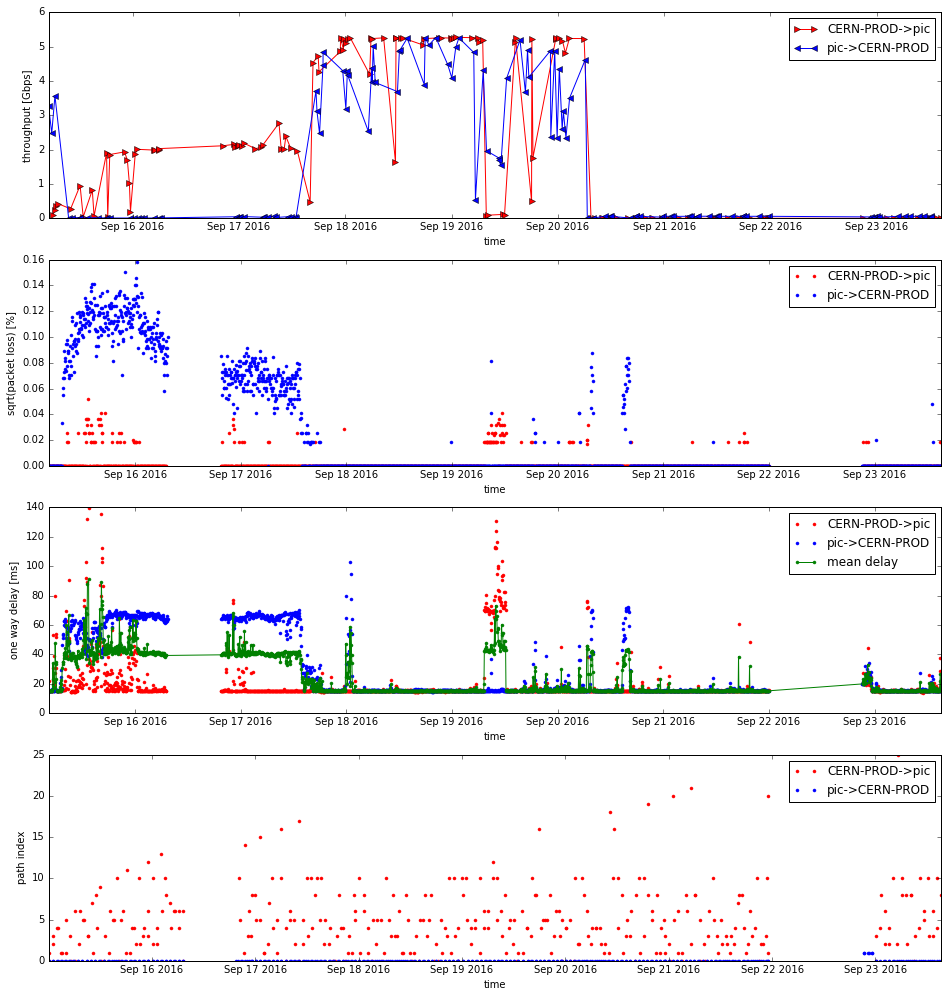

In [10]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

ax0 = plt.subplot(gs[0])
ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#ax0.xlim(xmin=0)
ax0.legend()

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

ax4 = plt.subplot(gs[2])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()

ax6 = plt.subplot(gs[3])
ax6.plot(Fh.timestamp.tolist(), Fids, ls='', marker='.', c='r', label=sS+'->'+dS)
ax6.plot(Bh.timestamp.tolist(), Bids, ls='', marker='.', c='b', label=dS+'->'+sS)
ax6.set_xlabel('time')
ax6.set_ylabel('path index')
ax6.legend()

plt.savefig('Plots/4PlotForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

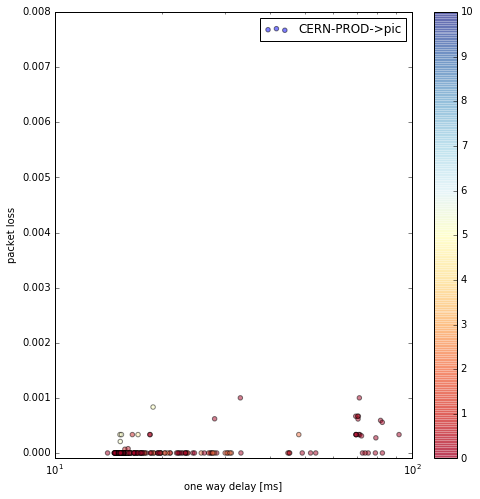

In [11]:
plt.figure(figsize=[8, 8])

#print (NFall.delay_mean.tolist(),NFall.throughput.tolist(),NFall.packet_loss.tolist())

cm = plt.cm.get_cmap('RdYlBu')

sc=plt.scatter(NFall.delay_mean.tolist(), NFall.packet_loss.tolist(), c=NFall.throughput.tolist(), vmin=0, vmax=10, cmap=cm, alpha=0.5, label=sS+'->'+dS)
#plt.scatter(NBall.delay_mean.tolist(), NBall.packet_loss.tolist(), c=NBall.throughput.tolist(), vmin=0, vmax=10, cmap=cm, alpha=0.5, label=dS+'->'+sS)
plt.xlabel('one way delay [ms]')
plt.ylabel('packet loss')#,rotation='horizontal')
plt.ylim(ymin=-0.0001)
plt.xscale("log")
plt.colorbar(sc)
plt.legend()

#ax2 = plt.subplot(gs[1])
#heatmap = ax2.pcolor(NFall.delay_mean.tolist(), NFall.throughput.tolist(), NFall.delay_mean.tolist(), cmap='PuBu_r')
# ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
# ax2.set_xlabel('time')
# ax2.set_ylabel('sqrt(packet loss) [%]')
# ax2.legend()

# ax4 = plt.subplot(gs[2])
# ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
# ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
# ax4.set_xlabel('time')
# ax4.set_ylabel('one way delay [ms]')
# ax4.legend()


plt.savefig('Plots/CorrelationPlotsForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

## learn SVR over 70% of data

In [12]:
from sklearn import svm
trainingSetSize=int(NFall.shape[0]*.7)
XP = NFall[['delay_mean', 'packet_loss']].iloc[:trainingSetSize].values
XT = NFall[['delay_mean', 'packet_loss']].iloc[trainingSetSize:].values
y = np.ravel(NFall[[ 'throughput']].values.tolist()).tolist()
yP=y[:trainingSetSize]
yT=y[trainingSetSize:]
print('training set: ',XP.shape[0], 'testing set:', XT.shape[0])
print(len(yP),len(yT))

training set:  337 testing set: 145
337 145


In [13]:
clf = svm.SVR()
f = clf.fit(XP, yP)
print(f)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


### predict for the rest of data

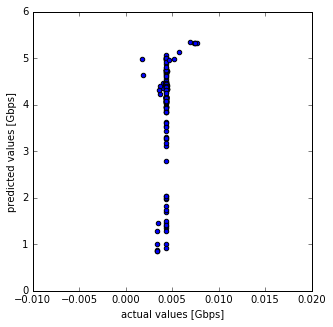

In [14]:
tP=clf.predict(XT)
#TP

plt.figure(figsize=[5, 5])
plt.scatter(yT,tP)
plt.xlabel('actual values [Gbps]')
plt.ylabel('predicted values [Gbps]')

plt.savefig('Plots/SVRpredictionResults' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

In [15]:
res = yT-tP
res.std()

1.1354662049025546